moving bar with constant velocity

Test the effect of separation of center and surround filter

based on: "Berry_new_gain_control-extraoridnary" from David

Update history: verion 01 creation, Apr. 9, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
%matplotlib inline

In [2]:
##Temporal kernal (center)
def temporal_center(t):
    k1 = 2.2
    sigma_1 = 1
    u1 = 3
    kernal1 = (k1/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(t-u1)**2/(2*sigma_1**2))
    return kernal1

##Temporal kernal (surround)
def temporal_surround(t):
    k2 = 2
    sigma_2 = 2
    u2 = 8
    kernal2 = (k2/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(t-u2)**2/(2*sigma_2**2))
    return -kernal2

##Temporal kernal (center+surround)
def temporal(t):
    k1 = 2.2
    sigma_1 = 1
    u1 = 3
    k2 = 2
    sigma_2 = 2
    u2 = 8
    kernal1 = (k1/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(t-u1)**2/(2*sigma_1**2))
    kernal2 = (k2/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(t-u2)**2/(2*sigma_2**2))
    return kernal1-kernal2

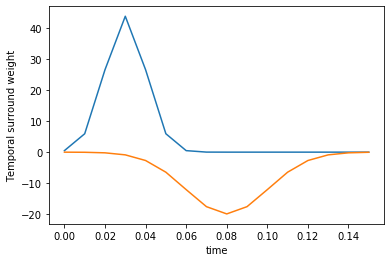

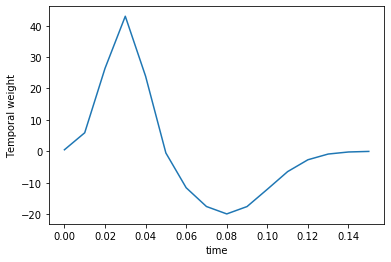

In [3]:
#Make Temporal kernal (center)
length = 15
dt = 0.01
tp_center = temporal_center(np.arange(0,length+1))
tp_center = tp_center*50
plt.plot(np.arange(0,length+1)*dt,tp_center)
plt.xlabel('time')
plt.ylabel('Temporal center weight ')
temp_pre = np.zeros(length)
tp = np.concatenate((temp_pre,tp_center))

#Make Temporal kernal (surround)
tp_surround = temporal_surround(np.arange(0,length+1))
tp_surround = tp_surround*50
plt.plot(np.arange(0,length+1)*dt,tp_surround)
plt.xlabel('time')
plt.ylabel('Temporal surround weight')
temp_pre = np.zeros(length)
tp = np.concatenate((temp_pre,tp_surround))

#Make Temporal kernal (center+surround)
tp = temporal(np.arange(0,length+1))
tp = tp*50
plt.figure()
plt.plot(np.arange(0,length+1)*dt,tp)
plt.xlabel('time')
plt.ylabel('Temporal weight')
temp_pre = np.zeros(length)
tp = np.concatenate((temp_pre,tp))

In [4]:
#Spatial kernal (center)
def spatial_center(x,u):
    sigma_1 = 0.5
    kernal1 = (3.5/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(x-u)**2/(2*sigma_1**2))
    return kernal1

#Spatial kernal (surround)
def spatial_surround(x,u):
    sigma_2 = 2
    kernal2 = (3/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(x-u)**2/(2*sigma_2**2))
    return kernal2

#Spatial kernal (center+surround)
def spatial(x,u):
    sigma_1 = 0.5
    sigma_2 = 2
    kernal1 = (3.5/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(x-u)**2/(2*sigma_1**2))
    kernal2 = (3/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(x-u)**2/(2*sigma_2**2))
    return kernal1-kernal2

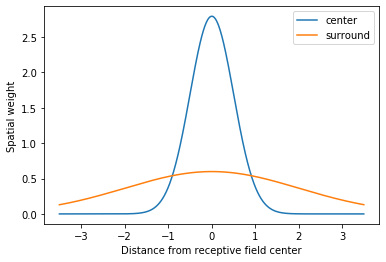

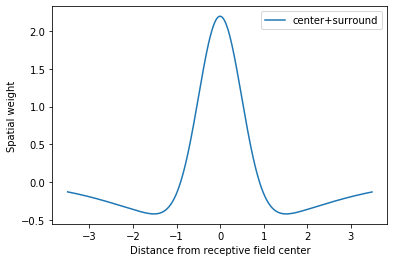

In [5]:
#Make Spatial kernal
sigma_c = 1#RF size of horizontal cell
dx = 0.01*sigma_c

sp_center = spatial_center(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),0)
sp_surround = spatial_surround(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),0)
sp = spatial(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),0)

plt.plot(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),sp_center,label='center')
plt.plot(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),sp_surround,label='surround')
plt.xlabel('Distance from receptive field center')
plt.ylabel('Spatial weight')
plt.legend()

plt.figure()
plt.plot(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),sp,label='center+surround')
plt.xlabel('Distance from receptive field center')
plt.ylabel('Spatial weight')
plt.legend()

In [6]:
xlen = 15*sigma_c#spatial extend of simulation
hw = 0.5*sigma_c#half bar width
pos_0 = 1.5*sigma_c#Where the bar start
nstep = 1000#time step of simulation
velocity = 1*sigma_c#speed of bar
contrast = 1#Contrast of bar

In [7]:
real_len = int(xlen/dx)#spatial width
s = np.zeros([real_len,nstep])#stimulus
u = np.zeros([real_len,nstep])#Output

#Produce stimulus(x,t)
for i in range(nstep):
    #Bar position
    pos = pos_0+velocity*dt*i
    #Stimulus of bar
    s[int((pos-hw)/dx):int((pos+hw)/dx),i] = contrast

In [8]:
#center
temp = np.zeros([real_len,nstep])
spatial_center = np.zeros([real_len,nstep])#Linear filter output
#Spatial convolution (center)
for i in range(nstep):
    temp[:,i] = np.convolve(s[:,i],sp_center,'same')*dx
#Temporal convolution (center)
for j in range(real_len):
    spatial_center[j,:] = np.convolve(tp_center,temp[j,:],'same')*dt

#surround
temp = np.zeros([real_len,nstep])
spatial_surround = np.zeros([real_len,nstep])#Linear filter output
#Spatial convolution (surround)
for i in range(nstep):
    temp[:,i] = np.convolve(s[:,i],sp_surround,'same')*dx
#Temporal convolution (surround)
for j in range(real_len):
    spatial_surround[j,:] = np.convolve(tp_surround,temp[j,:],'same')*dt
##Add center and surround
spatial_separate = spatial_center + spatial_surround

#center+surround
temp = np.zeros([real_len,nstep])
spatial_merge = np.zeros([real_len,nstep])#Linear filter output
#Spatial convolution (center+surround)
for i in range(nstep):
    temp[:,i] = np.convolve(s[:,i],sp,'same')*dx
#Temporal convolution (center+surround)
for j in range(real_len):
    spatial_merge[j,:] = np.convolve(tp,temp[j,:],'same')*dt

Text(0.5, 1.0, 'Center and surround')

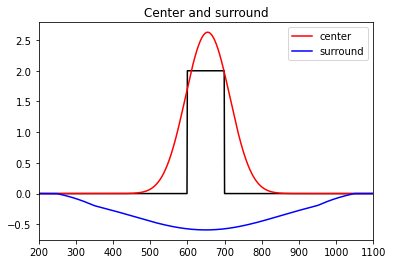

In [9]:
k = 500
plt.plot(s[:,k]*2,'k')
plt.plot(spatial_center[:,k],'r',label='center')
plt.plot(spatial_surround[:,k],'b',label='surround')
plt.legend()
plt.xlim([200,1100])
plt.title('Center and surround')

Text(0.5, 1.0, 'Effect of separation')

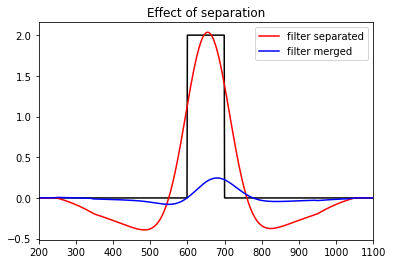

In [10]:
k = 500
plt.plot(s[:,k]*2,'k')
plt.plot(spatial_separate[:,k],'r',label='filter separated')
plt.plot(spatial_merge[:,k],'b',label='filter merged')
plt.legend()
plt.xlim([200,1100])
plt.title('Effect of separation')

Text(0.5, 1.0, 'Effect of separation')

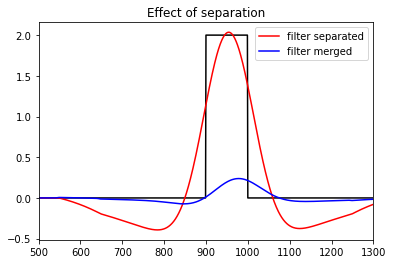

In [11]:
k = 800
plt.plot(s[:,k]*2,'k')
plt.plot(spatial_separate[:,k],'r',label='filter separated')
plt.plot(spatial_merge[:,k],'b',label='filter merged')
plt.legend()
plt.xlim([500,1300])
plt.title('Effect of separation')